In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Libraries loaded successfully


## 1. Data Loading


In [3]:
# Load all training datasets
import os

# Works from notebooks/ folder or project root
if os.path.exists('../data/raw'):
    raw_path = '../data/raw'
    processed_path = '../data/processed'
elif os.path.exists('data/raw'):
    raw_path = 'data/raw'
    processed_path = 'data/processed'
else:
    # Absolute path fallback (adjust for your system)
    raw_path = r'c:\MachineLearning2\DataOrbit---HealthCare-Provider-Fraud-Detection-Project\data\raw'
    processed_path = r'c:\MachineLearning2\DataOrbit---HealthCare-Provider-Fraud-Detection-Project\data\processed'

os.makedirs(processed_path, exist_ok=True)

print("Loading datasets...")

# Load data
beneficiary = pd.read_csv(os.path.join(raw_path, 'Train_Beneficiarydata.csv'), low_memory=False)
inpatient = pd.read_csv(os.path.join(raw_path, 'Train_Inpatientdata.csv'), low_memory=False)
outpatient = pd.read_csv(os.path.join(raw_path, 'Train_Outpatientdata.csv'), low_memory=False)
labels = pd.read_csv(os.path.join(raw_path, 'Train_labels.csv'), low_memory=False)

print(f"\nDataset shapes:")
print(f"Beneficiary: {beneficiary.shape}")
print(f"Inpatient: {inpatient.shape}")
print(f"Outpatient: {outpatient.shape}")
print(f"Labels: {labels.shape}")

print(f"\nFirst few rows of labels:")
print(labels.head())
print(f"\nFraud distribution:")
print(labels['PotentialFraud'].value_counts())


Loading datasets...

Dataset shapes:
Beneficiary: (138556, 25)
Inpatient: (40474, 30)
Outpatient: (517737, 27)
Labels: (5410, 2)

First few rows of labels:
   Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes
2  PRV51004             No
3  PRV51005            Yes
4  PRV51007             No

Fraud distribution:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64


## 2. Data Quality Check


In [4]:
# Detailed missing values analysis
print("=== Missing Values Analysis ===")

print("\nBeneficiary Missing Values:")
beneficiary_missing = beneficiary.isnull().sum()
print(beneficiary_missing[beneficiary_missing > 0])

print("\nInpatient Missing Values:")
inpatient_missing = inpatient.isnull().sum()
print(inpatient_missing[inpatient_missing > 0].head(10))

print("\nOutpatient Missing Values:")
outpatient_missing = outpatient.isnull().sum()
print(outpatient_missing[outpatient_missing > 0].head(10))

# Check data types
print("\n=== Data Types ===")
print("\nBeneficiary columns:", len(beneficiary.columns))
print("Inpatient columns:", len(inpatient.columns))
print("Outpatient columns:", len(outpatient.columns))

# Basic statistics
print("\n=== Basic Statistics ===")
print(f"\nBeneficiary: {beneficiary.shape[0]} rows, {beneficiary.shape[1]} columns")
print(f"Inpatient: {inpatient.shape[0]} rows, {inpatient.shape[1]} columns")
print(f"Outpatient: {outpatient.shape[0]} rows, {outpatient.shape[1]} columns")
print(f"Labels: {labels.shape[0]} providers")


=== Missing Values Analysis ===

Beneficiary Missing Values:
DOD    137135
dtype: int64

Inpatient Missing Values:
AttendingPhysician      112
OperatingPhysician    16644
OtherPhysician        35784
DeductibleAmtPaid       899
ClmDiagnosisCode_2      226
ClmDiagnosisCode_3      676
ClmDiagnosisCode_4     1534
ClmDiagnosisCode_5     2894
ClmDiagnosisCode_6     4838
ClmDiagnosisCode_7     7258
dtype: int64

Outpatient Missing Values:
AttendingPhysician      1396
OperatingPhysician    427120
OtherPhysician        322691
ClmDiagnosisCode_1     10453
ClmDiagnosisCode_2    195380
ClmDiagnosisCode_3    314480
ClmDiagnosisCode_4    392141
ClmDiagnosisCode_5    443393
ClmDiagnosisCode_6    468981
ClmDiagnosisCode_7    484776
dtype: int64

=== Data Types ===

Beneficiary columns: 25
Inpatient columns: 30
Outpatient columns: 27

=== Basic Statistics ===

Beneficiary: 138556 rows, 25 columns
Inpatient: 40474 rows, 30 columns
Outpatient: 517737 rows, 27 columns
Labels: 5410 providers


## 2.1 Exploratory Data Analysis - Target Variable


=== Fraud Distribution ===
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

Percentages:
Fraud: 9.35%
Non-Fraud: 90.65%


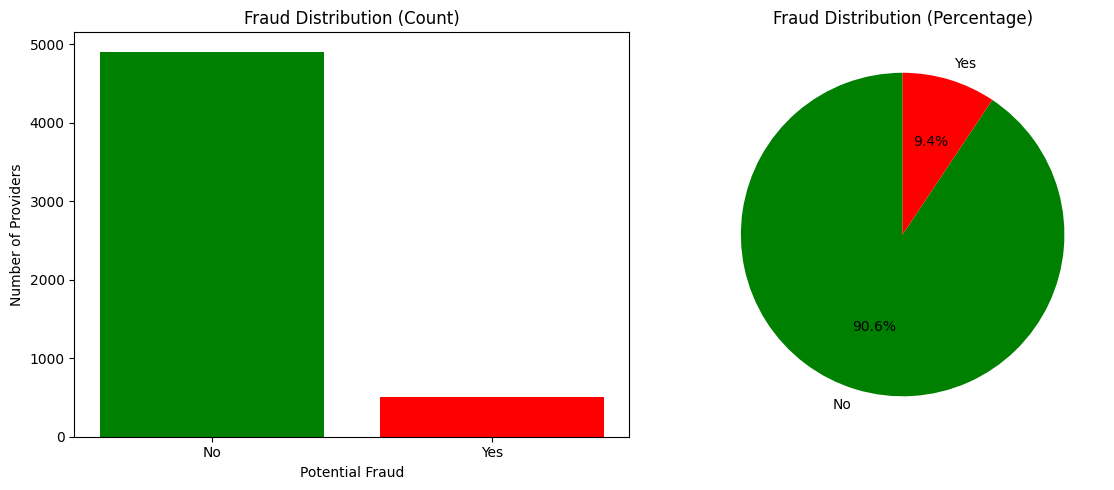


⚠️ Class Imbalance: 9.4% fraud rate - will need special handling!


In [5]:
# Target variable distribution
fraud_counts = labels['PotentialFraud'].value_counts()
fraud_pct = labels['PotentialFraud'].value_counts(normalize=True) * 100

print("=== Fraud Distribution ===")
print(fraud_counts)
print(f"\nPercentages:")
print(f"Fraud: {fraud_pct['Yes']:.2f}%")
print(f"Non-Fraud: {fraud_pct['No']:.2f}%")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
axes[0].bar(fraud_counts.index, fraud_counts.values, color=['green', 'red'])
axes[0].set_title('Fraud Distribution (Count)')
axes[0].set_xlabel('Potential Fraud')
axes[0].set_ylabel('Number of Providers')
axes[0].set_xticks(['No', 'Yes'])

# Pie chart
axes[1].pie(fraud_counts.values, labels=fraud_counts.index, autopct='%1.1f%%', 
            colors=['green', 'red'], startangle=90)
axes[1].set_title('Fraud Distribution (Percentage)')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Class Imbalance: {fraud_pct['Yes']:.1f}% fraud rate - will need special handling!")


## 2.2 Exploratory Data Analysis - Beneficiary Data


In [6]:
# Beneficiary demographics analysis
print("=== Beneficiary Demographics ===")

# Calculate age first (temporary for EDA)
beneficiary_temp = beneficiary.copy()
beneficiary_temp['DOB'] = pd.to_datetime(beneficiary_temp['DOB'], errors='coerce')
beneficiary_temp['Age'] = (pd.Timestamp('2009-12-31') - beneficiary_temp['DOB']).dt.days / 365.25

# Gender distribution
gender_counts = beneficiary['Gender'].value_counts()
print(f"\nGender Distribution:")
print(f"Male (1): {gender_counts.get(1, 0)} ({gender_counts.get(1, 0)/len(beneficiary)*100:.1f}%)")
print(f"Female (2): {gender_counts.get(2, 0)} ({gender_counts.get(2, 0)/len(beneficiary)*100:.1f}%)")

# Age statistics
print(f"\nAge Statistics:")
print(f"Mean Age: {beneficiary_temp['Age'].mean():.1f} years")
print(f"Median Age: {beneficiary_temp['Age'].median():.1f} years")
print(f"Min Age: {beneficiary_temp['Age'].min():.1f} years")
print(f"Max Age: {beneficiary_temp['Age'].max():.1f} years")

# Chronic conditions summary
chronic_cols = [col for col in beneficiary.columns if col.startswith('ChronicCond_')]
chronic_summary = {}
for col in chronic_cols:
    chronic_summary[col.replace('ChronicCond_', '')] = (beneficiary[col] == 1).sum()

print(f"\nChronic Conditions (Patients with condition):")
for condition, count in sorted(chronic_summary.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(beneficiary) * 100
    print(f"  {condition}: {count} ({pct:.1f}%)")


=== Beneficiary Demographics ===

Gender Distribution:
Male (1): 59450 (42.9%)
Female (2): 79106 (57.1%)

Age Statistics:
Mean Age: 73.7 years
Median Age: 74.3 years
Min Age: 26.1 years
Max Age: 101.0 years

Chronic Conditions (Patients with condition):
  IschemicHeart: 93644 (67.6%)
  Diabetes: 83391 (60.2%)
  Heartfailure: 68402 (49.4%)
  Depression: 49260 (35.6%)
  Alzheimer: 46026 (33.2%)
  KidneyDisease: 43279 (31.2%)
  Osteoporasis: 38059 (27.5%)
  rheumatoidarthritis: 35584 (25.7%)
  ObstrPulmonary: 32859 (23.7%)
  Cancer: 16621 (12.0%)
  stroke: 10954 (7.9%)


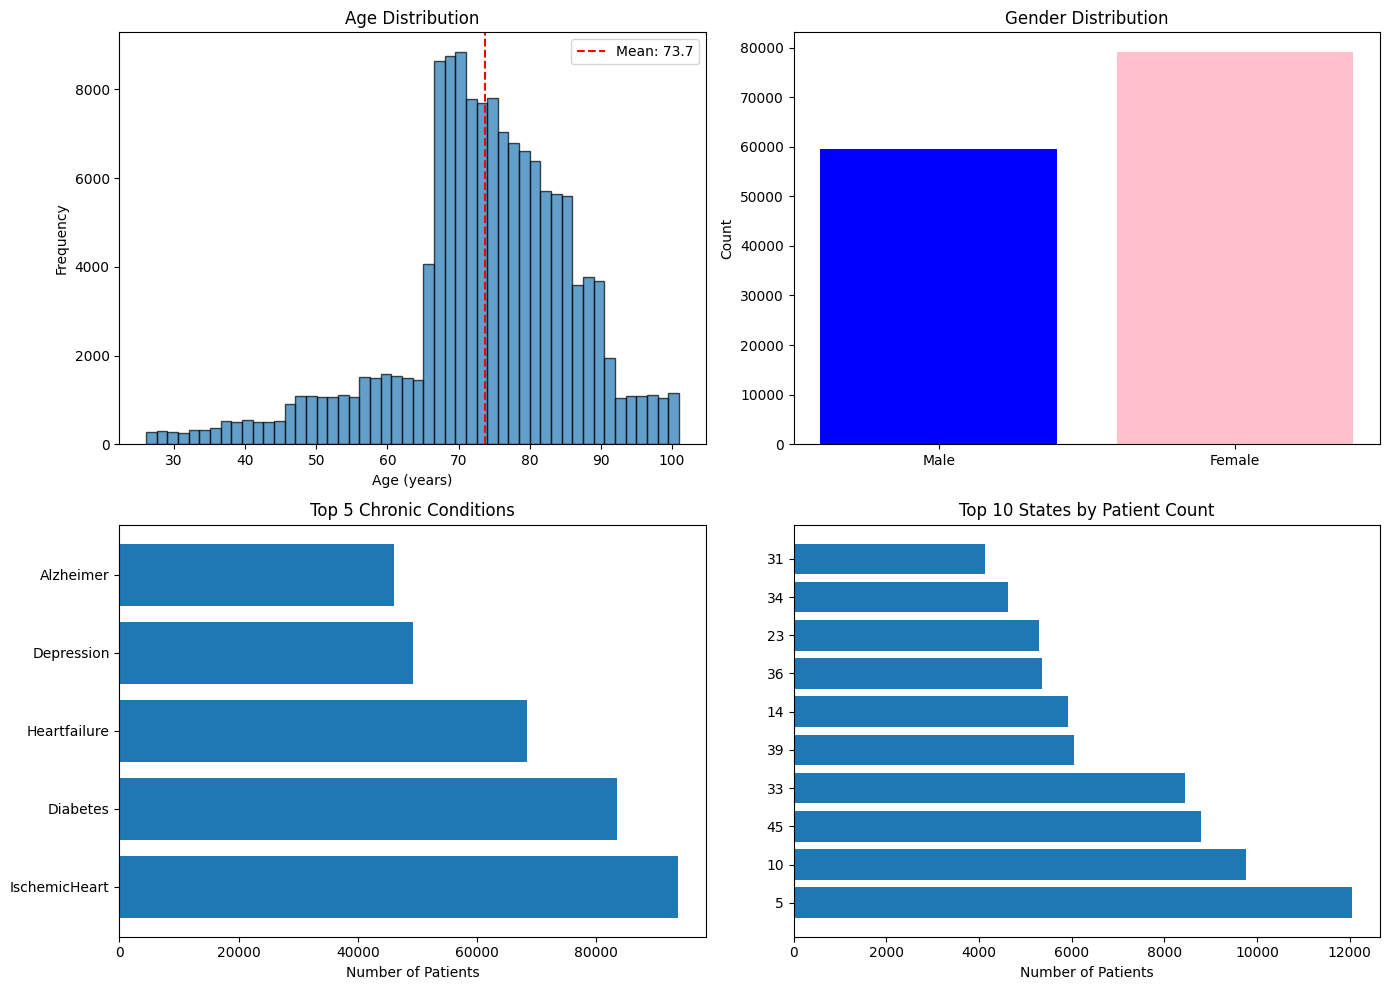

In [7]:
# Visualize beneficiary demographics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(beneficiary_temp['Age'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(beneficiary_temp['Age'].mean(), color='red', linestyle='--', label=f'Mean: {beneficiary_temp["Age"].mean():.1f}')
axes[0, 0].legend()

# Gender distribution
gender_counts = beneficiary['Gender'].value_counts()
axes[0, 1].bar(['Male', 'Female'], [gender_counts.get(1, 0), gender_counts.get(2, 0)], 
               color=['blue', 'pink'])
axes[0, 1].set_title('Gender Distribution')
axes[0, 1].set_ylabel('Count')

# Top chronic conditions
top_chronic = sorted(chronic_summary.items(), key=lambda x: x[1], reverse=True)[:5]
axes[1, 0].barh([c[0] for c in top_chronic], [c[1] for c in top_chronic])
axes[1, 0].set_title('Top 5 Chronic Conditions')
axes[1, 0].set_xlabel('Number of Patients')

# State distribution (top 10)
state_counts = beneficiary['State'].value_counts().head(10)
axes[1, 1].barh(range(len(state_counts)), state_counts.values)
axes[1, 1].set_yticks(range(len(state_counts)))
axes[1, 1].set_yticklabels(state_counts.index)
axes[1, 1].set_title('Top 10 States by Patient Count')
axes[1, 1].set_xlabel('Number of Patients')

plt.tight_layout()
plt.show()


## 2.3 Exploratory Data Analysis - Claim Data


In [8]:
# Claim amount analysis
print("=== Claim Amount Analysis ===")

print(f"\nInpatient Claims:")
print(f"  Total Claims: {len(inpatient):,}")
print(f"  Total Amount: ${inpatient['InscClaimAmtReimbursed'].sum():,.2f}")
print(f"  Average Claim: ${inpatient['InscClaimAmtReimbursed'].mean():,.2f}")
print(f"  Median Claim: ${inpatient['InscClaimAmtReimbursed'].median():,.2f}")
print(f"  Max Claim: ${inpatient['InscClaimAmtReimbursed'].max():,.2f}")

print(f"\nOutpatient Claims:")
print(f"  Total Claims: {len(outpatient):,}")
print(f"  Total Amount: ${outpatient['InscClaimAmtReimbursed'].sum():,.2f}")
print(f"  Average Claim: ${outpatient['InscClaimAmtReimbursed'].mean():,.2f}")
print(f"  Median Claim: ${outpatient['InscClaimAmtReimbursed'].median():,.2f}")
print(f"  Max Claim: ${outpatient['InscClaimAmtReimbursed'].max():,.2f}")

# Provider-level claim statistics
inpatient_by_provider = inpatient.groupby('Provider')['InscClaimAmtReimbursed'].agg(['sum', 'count', 'mean'])
outpatient_by_provider = outpatient.groupby('Provider')['InscClaimAmtReimbursed'].agg(['sum', 'count', 'mean'])

print(f"\nProvider-Level Statistics:")
print(f"  Providers with Inpatient Claims: {len(inpatient_by_provider):,}")
print(f"  Providers with Outpatient Claims: {len(outpatient_by_provider):,}")
print(f"  Avg Inpatient Claims per Provider: {inpatient_by_provider['count'].mean():.1f}")
print(f"  Avg Outpatient Claims per Provider: {outpatient_by_provider['count'].mean():.1f}")


=== Claim Amount Analysis ===

Inpatient Claims:
  Total Claims: 40,474
  Total Amount: $408,297,020.00
  Average Claim: $10,087.88
  Median Claim: $7,000.00
  Max Claim: $125,000.00

Outpatient Claims:
  Total Claims: 517,737
  Total Amount: $148,246,120.00
  Average Claim: $286.33
  Median Claim: $80.00
  Max Claim: $102,500.00

Provider-Level Statistics:
  Providers with Inpatient Claims: 2,092
  Providers with Outpatient Claims: 5,012
  Avg Inpatient Claims per Provider: 19.3
  Avg Outpatient Claims per Provider: 103.3


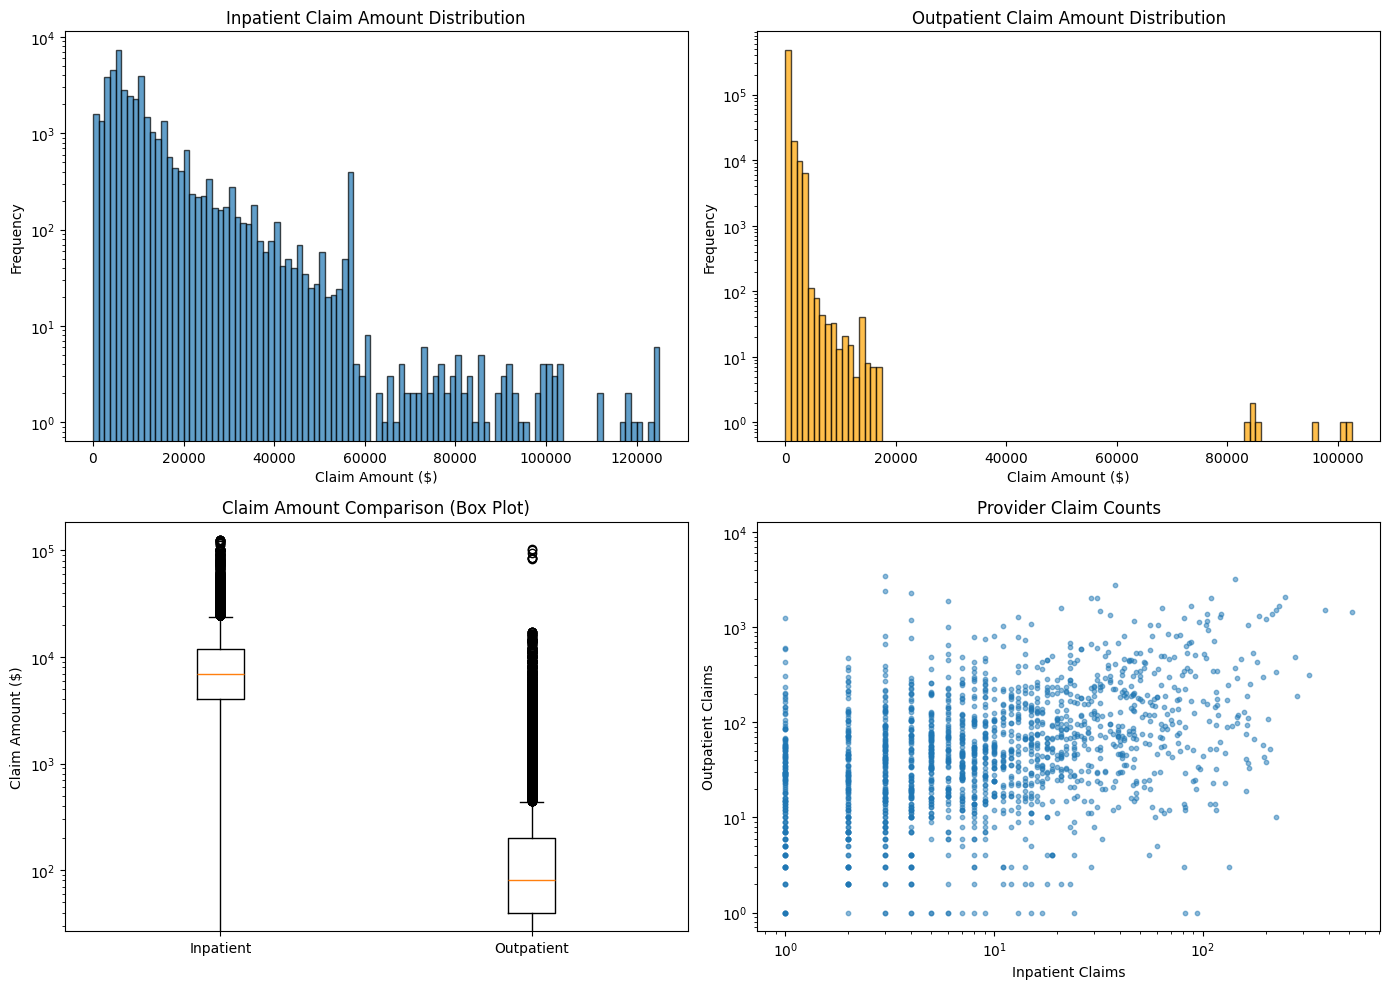

In [9]:
# Visualize claim distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Inpatient claim amounts (log scale due to outliers)
axes[0, 0].hist(inpatient['InscClaimAmtReimbursed'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Inpatient Claim Amount Distribution')
axes[0, 0].set_xlabel('Claim Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# Outpatient claim amounts
axes[0, 1].hist(outpatient['InscClaimAmtReimbursed'], bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Outpatient Claim Amount Distribution')
axes[0, 1].set_xlabel('Claim Amount ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# Box plots comparing IP vs OP
claim_data = pd.DataFrame({
    'Inpatient': inpatient['InscClaimAmtReimbursed'],
    'Outpatient': outpatient['InscClaimAmtReimbursed']
})
axes[1, 0].boxplot([claim_data['Inpatient'].dropna(), claim_data['Outpatient'].dropna()], 
                   labels=['Inpatient', 'Outpatient'])
axes[1, 0].set_title('Claim Amount Comparison (Box Plot)')
axes[1, 0].set_ylabel('Claim Amount ($)')
axes[1, 0].set_yscale('log')

# Provider claim counts
provider_claim_counts = pd.concat([
    inpatient.groupby('Provider').size().rename('Inpatient'),
    outpatient.groupby('Provider').size().rename('Outpatient')
], axis=1).fillna(0)
axes[1, 1].scatter(provider_claim_counts['Inpatient'], provider_claim_counts['Outpatient'], 
                   alpha=0.5, s=10)
axes[1, 1].set_title('Provider Claim Counts')
axes[1, 1].set_xlabel('Inpatient Claims')
axes[1, 1].set_ylabel('Outpatient Claims')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


## 2.4 Statistical Comparison: Fraud vs Non-Fraud Providers


In [10]:
# Merge labels with claim data for comparison
inpatient_with_labels = inpatient.merge(labels, on='Provider', how='left')
outpatient_with_labels = outpatient.merge(labels, on='Provider', how='left')

# Compare claim amounts: Fraud vs Non-Fraud
print("=== Fraud vs Non-Fraud: Claim Amount Comparison ===")

ip_fraud = inpatient_with_labels[inpatient_with_labels['PotentialFraud'] == 'Yes']['InscClaimAmtReimbursed']
ip_nonfraud = inpatient_with_labels[inpatient_with_labels['PotentialFraud'] == 'No']['InscClaimAmtReimbursed']

op_fraud = outpatient_with_labels[outpatient_with_labels['PotentialFraud'] == 'Yes']['InscClaimAmtReimbursed']
op_nonfraud = outpatient_with_labels[outpatient_with_labels['PotentialFraud'] == 'No']['InscClaimAmtReimbursed']

print(f"\nInpatient Claims:")
print(f"  Fraud - Mean: ${ip_fraud.mean():,.2f}, Median: ${ip_fraud.median():,.2f}")
print(f"  Non-Fraud - Mean: ${ip_nonfraud.mean():,.2f}, Median: ${ip_nonfraud.median():,.2f}")
print(f"  Difference: {((ip_fraud.mean() - ip_nonfraud.mean()) / ip_nonfraud.mean() * 100):.1f}%")

print(f"\nOutpatient Claims:")
print(f"  Fraud - Mean: ${op_fraud.mean():,.2f}, Median: ${op_fraud.median():,.2f}")
print(f"  Non-Fraud - Mean: ${op_nonfraud.mean():,.2f}, Median: ${op_nonfraud.median():,.2f}")
print(f"  Difference: {((op_fraud.mean() - op_nonfraud.mean()) / op_nonfraud.mean() * 100):.1f}%")

# Provider-level aggregations for comparison
ip_provider_fraud = inpatient_with_labels.groupby(['Provider', 'PotentialFraud'])['InscClaimAmtReimbursed'].sum().reset_index()
op_provider_fraud = outpatient_with_labels.groupby(['Provider', 'PotentialFraud'])['InscClaimAmtReimbursed'].sum().reset_index()

print(f"\nProvider-Level Totals:")
ip_fraud_providers = ip_provider_fraud[ip_provider_fraud['PotentialFraud'] == 'Yes']['InscClaimAmtReimbursed']
ip_nonfraud_providers = ip_provider_fraud[ip_provider_fraud['PotentialFraud'] == 'No']['InscClaimAmtReimbursed']
print(f"  Inpatient - Fraud providers avg total: ${ip_fraud_providers.mean():,.2f}")
print(f"  Inpatient - Non-Fraud providers avg total: ${ip_nonfraud_providers.mean():,.2f}")


=== Fraud vs Non-Fraud: Claim Amount Comparison ===

Inpatient Claims:
  Fraud - Mean: $10,310.59, Median: $7,000.00
  Non-Fraud - Mean: $9,782.60, Median: $7,000.00
  Difference: 5.4%

Outpatient Claims:
  Fraud - Mean: $287.19, Median: $80.00
  Non-Fraud - Mean: $285.84, Median: $80.00
  Difference: 0.5%

Provider-Level Totals:
  Inpatient - Fraud providers avg total: $548,382.98
  Inpatient - Non-Fraud providers avg total: $101,094.74


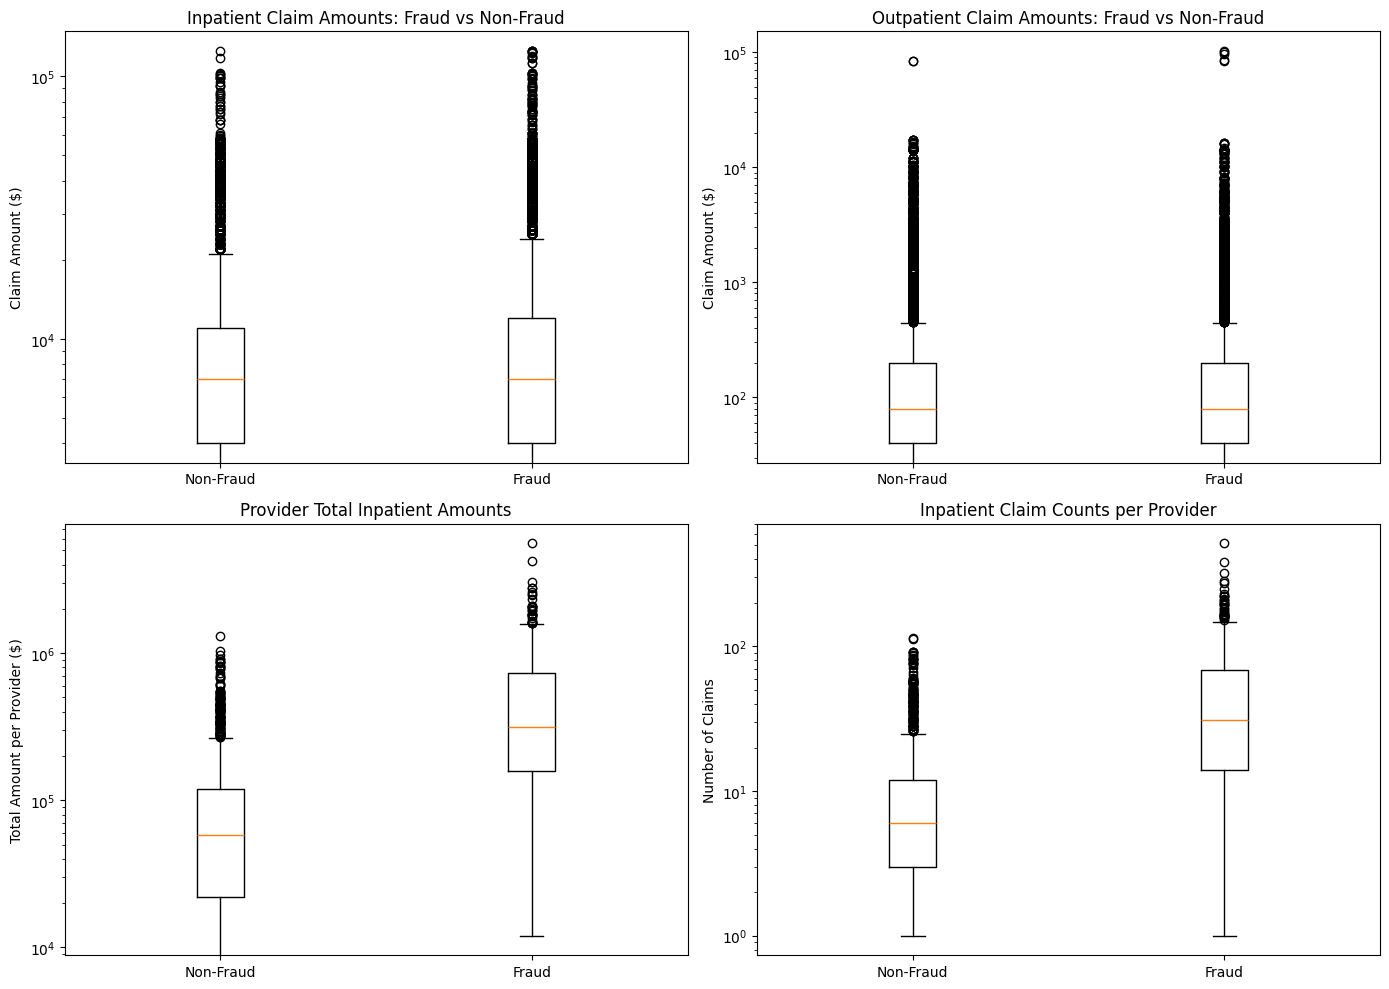

In [11]:
# Visualize fraud vs non-fraud comparisons
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Inpatient claim amounts comparison
axes[0, 0].boxplot([ip_nonfraud.dropna(), ip_fraud.dropna()], 
                   labels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_title('Inpatient Claim Amounts: Fraud vs Non-Fraud')
axes[0, 0].set_ylabel('Claim Amount ($)')
axes[0, 0].set_yscale('log')

# Outpatient claim amounts comparison
axes[0, 1].boxplot([op_nonfraud.dropna(), op_fraud.dropna()], 
                   labels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('Outpatient Claim Amounts: Fraud vs Non-Fraud')
axes[0, 1].set_ylabel('Claim Amount ($)')
axes[0, 1].set_yscale('log')

# Provider total amounts (inpatient)
axes[1, 0].boxplot([ip_nonfraud_providers.dropna(), ip_fraud_providers.dropna()], 
                   labels=['Non-Fraud', 'Fraud'])
axes[1, 0].set_title('Provider Total Inpatient Amounts')
axes[1, 0].set_ylabel('Total Amount per Provider ($)')
axes[1, 0].set_yscale('log')

# Claim counts per provider
ip_claim_counts = inpatient_with_labels.groupby(['Provider', 'PotentialFraud']).size().reset_index(name='ClaimCount')
ip_counts_fraud = ip_claim_counts[ip_claim_counts['PotentialFraud'] == 'Yes']['ClaimCount']
ip_counts_nonfraud = ip_claim_counts[ip_claim_counts['PotentialFraud'] == 'No']['ClaimCount']

axes[1, 1].boxplot([ip_counts_nonfraud.dropna(), ip_counts_fraud.dropna()], 
                   labels=['Non-Fraud', 'Fraud'])
axes[1, 1].set_title('Inpatient Claim Counts per Provider')
axes[1, 1].set_ylabel('Number of Claims')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


## 2.5 Data Relationships and Join Keys Verification


In [12]:
# Verify data relationships
print("=== Data Relationships Verification ===")

# Check unique counts
print(f"\nUnique Beneficiaries: {beneficiary['BeneID'].nunique():,}")
print(f"Unique Providers: {labels['Provider'].nunique():,}")
print(f"Unique Providers in Inpatient: {inpatient['Provider'].nunique():,}")
print(f"Unique Providers in Outpatient: {outpatient['Provider'].nunique():,}")

# Check if all providers in labels have claims
providers_with_ip = set(inpatient['Provider'].unique())
providers_with_op = set(outpatient['Provider'].unique())
providers_with_claims = providers_with_ip.union(providers_with_op)
providers_in_labels = set(labels['Provider'].unique())

print(f"\nProviders in labels: {len(providers_in_labels)}")
print(f"Providers with claims: {len(providers_with_claims)}")
print(f"Providers with both IP and OP: {len(providers_with_ip.intersection(providers_with_op))}")

# Check beneficiaries in claims
benes_in_ip = set(inpatient['BeneID'].unique())
benes_in_op = set(outpatient['BeneID'].unique())
benes_in_claims = benes_in_ip.union(benes_in_op)
benes_in_data = set(beneficiary['BeneID'].unique())

print(f"\nBeneficiaries in data: {len(benes_in_data):,}")
print(f"Beneficiaries in claims: {len(benes_in_claims):,}")
print(f"Coverage: {len(benes_in_claims.intersection(benes_in_data)) / len(benes_in_claims) * 100:.1f}%")

# Check for orphaned records
orphaned_providers = providers_in_labels - providers_with_claims
if orphaned_providers:
    print(f"\n⚠️ Warning: {len(orphaned_providers)} providers in labels have no claims")
else:
    print(f"\n✓ All providers in labels have claims")


=== Data Relationships Verification ===

Unique Beneficiaries: 138,556
Unique Providers: 5,410
Unique Providers in Inpatient: 2,092
Unique Providers in Outpatient: 5,012

Providers in labels: 5410
Providers with claims: 5410
Providers with both IP and OP: 1694

Beneficiaries in data: 138,556
Beneficiaries in claims: 138,556
Coverage: 100.0%

✓ All providers in labels have claims


## 2.6 Geographic Patterns Analysis


In [14]:
# Geographic patterns analysis
print("=== Geographic Patterns Analysis ===\n")

# Merge beneficiary data with claims to get provider locations
# Get provider locations from claims (through beneficiaries)
inpatient_with_beneficiary = inpatient.merge(beneficiary[['BeneID', 'State', 'County']], on='BeneID', how='left')
outpatient_with_beneficiary = outpatient.merge(beneficiary[['BeneID', 'State', 'County']], on='BeneID', how='left')

# Get unique states and counties per provider
provider_states_ip = inpatient_with_beneficiary.groupby('Provider')['State'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] if len(x) > 0 else None).to_frame('State_IP')
provider_states_op = outpatient_with_beneficiary.groupby('Provider')['State'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] if len(x) > 0 else None).to_frame('State_OP')

# Combine to get primary state per provider
provider_states = pd.concat([provider_states_ip, provider_states_op]).reset_index()
provider_states = provider_states.groupby('Provider')['State_IP'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] if len(x) > 0 else None).to_frame('PrimaryState')
provider_states = provider_states.reset_index()

# Merge with labels
provider_geo = labels.merge(provider_states, on='Provider', how='left')

# State-level fraud analysis
state_fraud = provider_geo.groupby('PrimaryState').agg({
    'PotentialFraud': ['count', lambda x: (x == 'Yes').sum(), lambda x: (x == 'Yes').mean()]
}).reset_index()
state_fraud.columns = ['State', 'TotalProviders', 'FraudProviders', 'FraudRate']
state_fraud = state_fraud.sort_values('TotalProviders', ascending=False)

print("Top 15 States by Provider Count:")
print(state_fraud.head(15).to_string(index=False))
print(f"\nStates with highest fraud rates (min 10 providers):")
high_fraud_states = state_fraud[state_fraud['TotalProviders'] >= 10].sort_values('FraudRate', ascending=False)
print(high_fraud_states.head(10).to_string(index=False))


=== Geographic Patterns Analysis ===

Top 15 States by Provider Count:
 State  TotalProviders  FraudProviders  FraudRate
   5.0             211              34   0.161137
  45.0             182              34   0.186813
  33.0             107              23   0.214953
  10.0              99              27   0.272727
  39.0              76              19   0.250000
  14.0              73               9   0.123288
  36.0              68              23   0.338235
  11.0              62               9   0.145161
  19.0              61               8   0.131148
  34.0              57              14   0.245614
   1.0              54              12   0.222222
  23.0              53              15   0.283019
  37.0              52               5   0.096154
  26.0              52              12   0.230769
  15.0              52               8   0.153846

States with highest fraud rates (min 10 providers):
 State  TotalProviders  FraudProviders  FraudRate
  21.0              14    

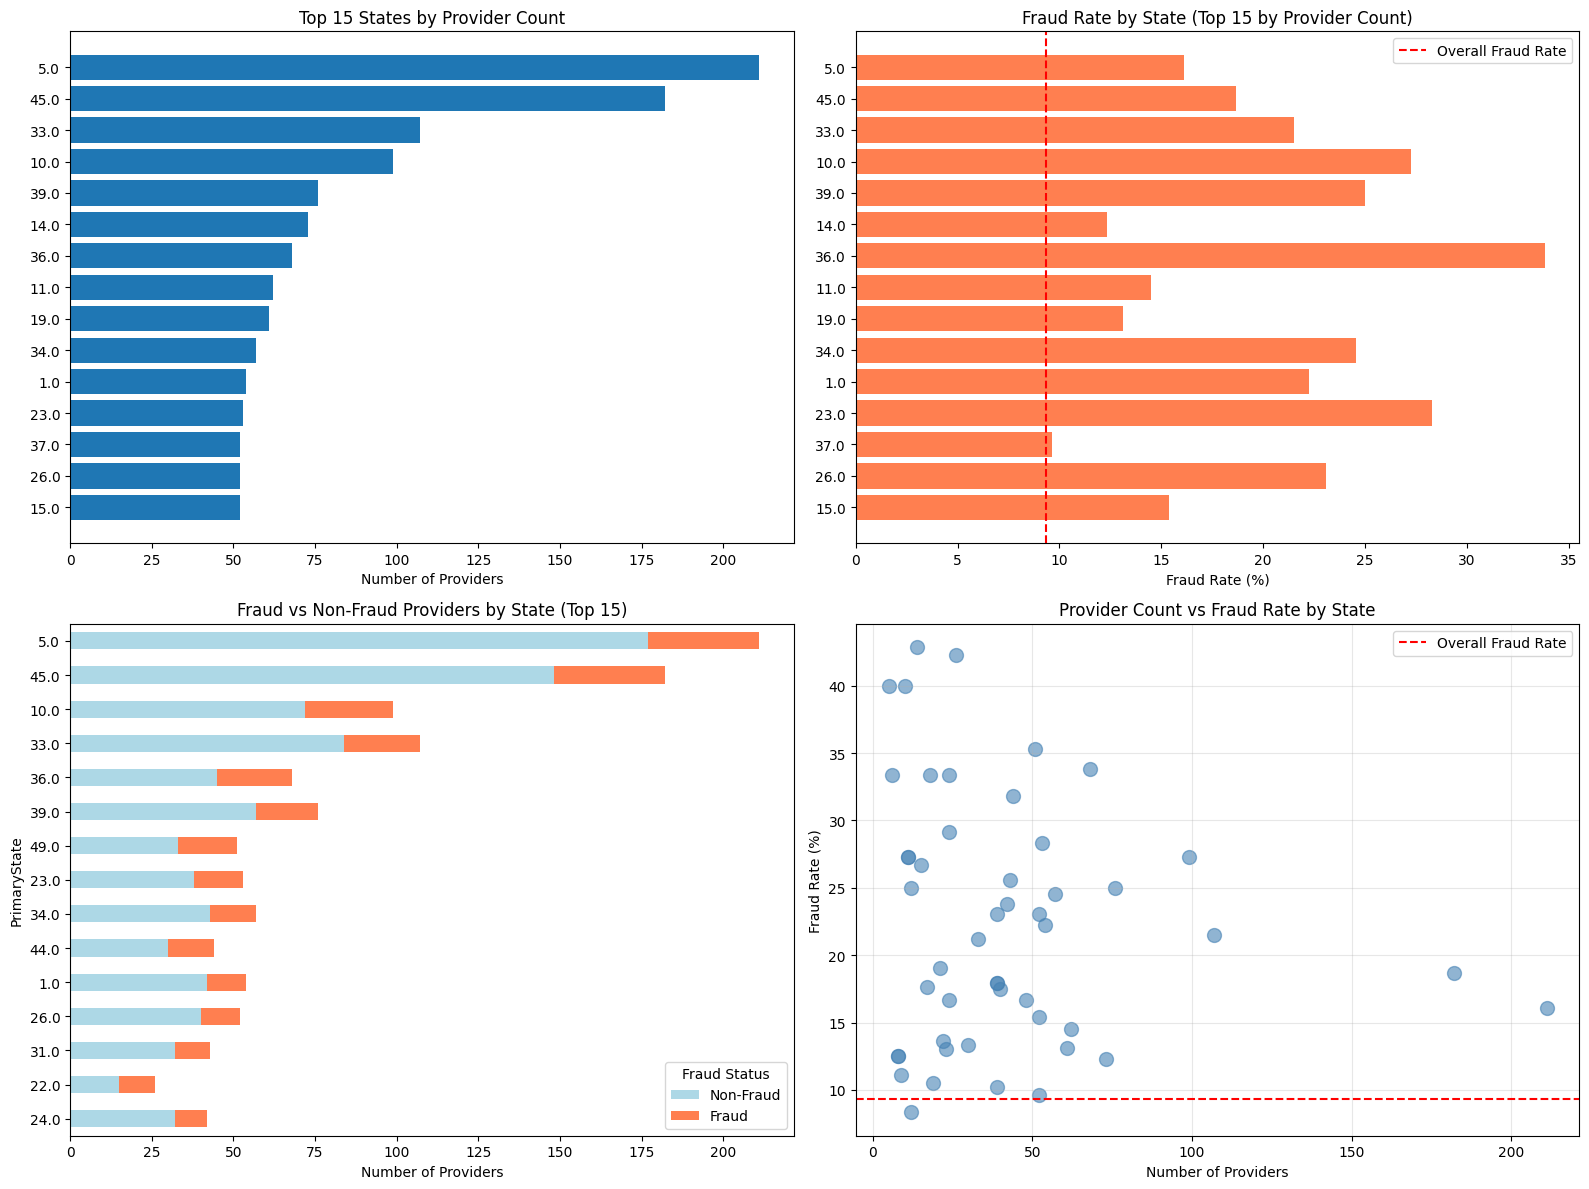


Geographic Insights:
  - States analyzed: 52
  - States with fraud rate > overall average: 43
  - State with highest fraud rate: 21.0 (42.9%)


In [15]:
# Visualize geographic patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Provider count by state (top 15)
top_states = state_fraud.head(15)
axes[0, 0].barh(range(len(top_states)), top_states['TotalProviders'].values)
axes[0, 0].set_yticks(range(len(top_states)))
axes[0, 0].set_yticklabels(top_states['State'].values)
axes[0, 0].set_xlabel('Number of Providers')
axes[0, 0].set_title('Top 15 States by Provider Count')
axes[0, 0].invert_yaxis()

# 2. Fraud rate by state (top 15 by provider count)
axes[0, 1].barh(range(len(top_states)), top_states['FraudRate'].values * 100, color='coral')
axes[0, 1].set_yticks(range(len(top_states)))
axes[0, 1].set_yticklabels(top_states['State'].values)
axes[0, 1].set_xlabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by State (Top 15 by Provider Count)')
axes[0, 1].axvline(x=provider_geo['PotentialFraud'].eq('Yes').mean() * 100, 
                   color='red', linestyle='--', label='Overall Fraud Rate')
axes[0, 1].legend()
axes[0, 1].invert_yaxis()

# 3. Fraud vs Non-Fraud provider distribution by state
state_comparison = provider_geo.groupby(['PrimaryState', 'PotentialFraud']).size().unstack(fill_value=0)
state_comparison = state_comparison.sort_values('Yes' if 'Yes' in state_comparison.columns else 'No', ascending=False).head(15)
state_comparison.plot(kind='barh', stacked=True, ax=axes[1, 0], color=['lightblue', 'coral'])
axes[1, 0].set_xlabel('Number of Providers')
axes[1, 0].set_title('Fraud vs Non-Fraud Providers by State (Top 15)')
axes[1, 0].legend(title='Fraud Status', labels=['Non-Fraud', 'Fraud'])
axes[1, 0].invert_yaxis()

# 4. Scatter plot: Provider count vs Fraud rate
states_with_min_providers = state_fraud[state_fraud['TotalProviders'] >= 5]
axes[1, 1].scatter(states_with_min_providers['TotalProviders'], 
                   states_with_min_providers['FraudRate'] * 100, 
                   s=100, alpha=0.6, color='steelblue')
axes[1, 1].set_xlabel('Number of Providers')
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].set_title('Provider Count vs Fraud Rate by State')
axes[1, 1].axhline(y=provider_geo['PotentialFraud'].eq('Yes').mean() * 100, 
                   color='red', linestyle='--', label='Overall Fraud Rate')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGeographic Insights:")
print(f"  - States analyzed: {len(state_fraud)}")
print(f"  - States with fraud rate > overall average: {len(high_fraud_states[high_fraud_states['FraudRate'] > provider_geo['PotentialFraud'].eq('Yes').mean()])}")
print(f"  - State with highest fraud rate: {high_fraud_states.iloc[0]['State']} ({high_fraud_states.iloc[0]['FraudRate']*100:.1f}%)")


## 2.7 Temporal Patterns Analysis


In [16]:
# Temporal patterns analysis
print("=== Temporal Patterns Analysis ===\n")

# Prepare date columns (if not already converted, convert them)
if 'ClaimStartDt' in inpatient.columns and not pd.api.types.is_datetime64_any_dtype(inpatient['ClaimStartDt']):
    inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'], errors='coerce')
if 'ClaimStartDt' in outpatient.columns and not pd.api.types.is_datetime64_any_dtype(outpatient['ClaimStartDt']):
    outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'], errors='coerce')

# Extract temporal features
inpatient['ClaimYear'] = inpatient['ClaimStartDt'].dt.year
inpatient['ClaimMonth'] = inpatient['ClaimStartDt'].dt.month
inpatient['ClaimQuarter'] = inpatient['ClaimStartDt'].dt.quarter

outpatient['ClaimYear'] = outpatient['ClaimStartDt'].dt.year
outpatient['ClaimMonth'] = outpatient['ClaimStartDt'].dt.month
outpatient['ClaimQuarter'] = outpatient['ClaimStartDt'].dt.quarter

# Merge with labels for fraud analysis
inpatient_with_labels = inpatient.merge(labels, on='Provider', how='left')
outpatient_with_labels = outpatient.merge(labels, on='Provider', how='left')

# Monthly claim trends
monthly_claims = pd.concat([
    inpatient_with_labels.groupby(['ClaimMonth', 'PotentialFraud']).size().reset_index(name='Count').assign(Type='Inpatient'),
    outpatient_with_labels.groupby(['ClaimMonth', 'PotentialFraud']).size().reset_index(name='Count').assign(Type='Outpatient')
])

# Quarterly trends
quarterly_claims = pd.concat([
    inpatient_with_labels.groupby(['ClaimQuarter', 'PotentialFraud']).size().reset_index(name='Count').assign(Type='Inpatient'),
    outpatient_with_labels.groupby(['ClaimQuarter', 'PotentialFraud']).size().reset_index(name='Count').assign(Type='Outpatient')
])

# Yearly trends
yearly_claims = pd.concat([
    inpatient_with_labels.groupby(['ClaimYear', 'PotentialFraud']).size().reset_index(name='Count').assign(Type='Inpatient'),
    outpatient_with_labels.groupby(['ClaimYear', 'PotentialFraud']).size().reset_index(name='Count').assign(Type='Outpatient')
])

print("Monthly Claim Distribution:")
monthly_summary = monthly_claims.groupby(['ClaimMonth', 'PotentialFraud'])['Count'].sum().unstack(fill_value=0)
print(monthly_summary)
print(f"\nQuarterly Claim Distribution:")
quarterly_summary = quarterly_claims.groupby(['ClaimQuarter', 'PotentialFraud'])['Count'].sum().unstack(fill_value=0)
print(quarterly_summary)
print(f"\nYearly Claim Distribution:")
yearly_summary = yearly_claims.groupby(['ClaimYear', 'PotentialFraud'])['Count'].sum().unstack(fill_value=0)
print(yearly_summary)

# Monthly fraud rate
monthly_fraud_rate = monthly_claims[monthly_claims['PotentialFraud'] == 'Yes'].groupby('ClaimMonth')['Count'].sum() / \
                     monthly_claims.groupby('ClaimMonth')['Count'].sum() * 100
print(f"\nMonthly Fraud Rate (%):")
print(monthly_fraud_rate.round(2))


=== Temporal Patterns Analysis ===

Monthly Claim Distribution:
PotentialFraud     No    Yes
ClaimMonth                  
1               30532  19050
2               27681  17110
3               30865  18769
4               29747  18337
5               30354  18905
6               29322  18078
7               29910  18138
8               29220  18290
9               27742  17158
10              27982  17122
11              26145  15957
12              25915  15882

Quarterly Claim Distribution:
PotentialFraud     No    Yes
ClaimQuarter                
1               89078  54929
2               89423  55320
3               86872  53586
4               80042  48961

Yearly Claim Distribution:
PotentialFraud      No     Yes
ClaimYear                     
2008              1586    1119
2009            343829  211677

Monthly Fraud Rate (%):
ClaimMonth
1     38.42
2     38.20
3     37.81
4     38.14
5     38.38
6     38.14
7     37.75
8     38.50
9     38.21
10    37.96
11    37.90
12   

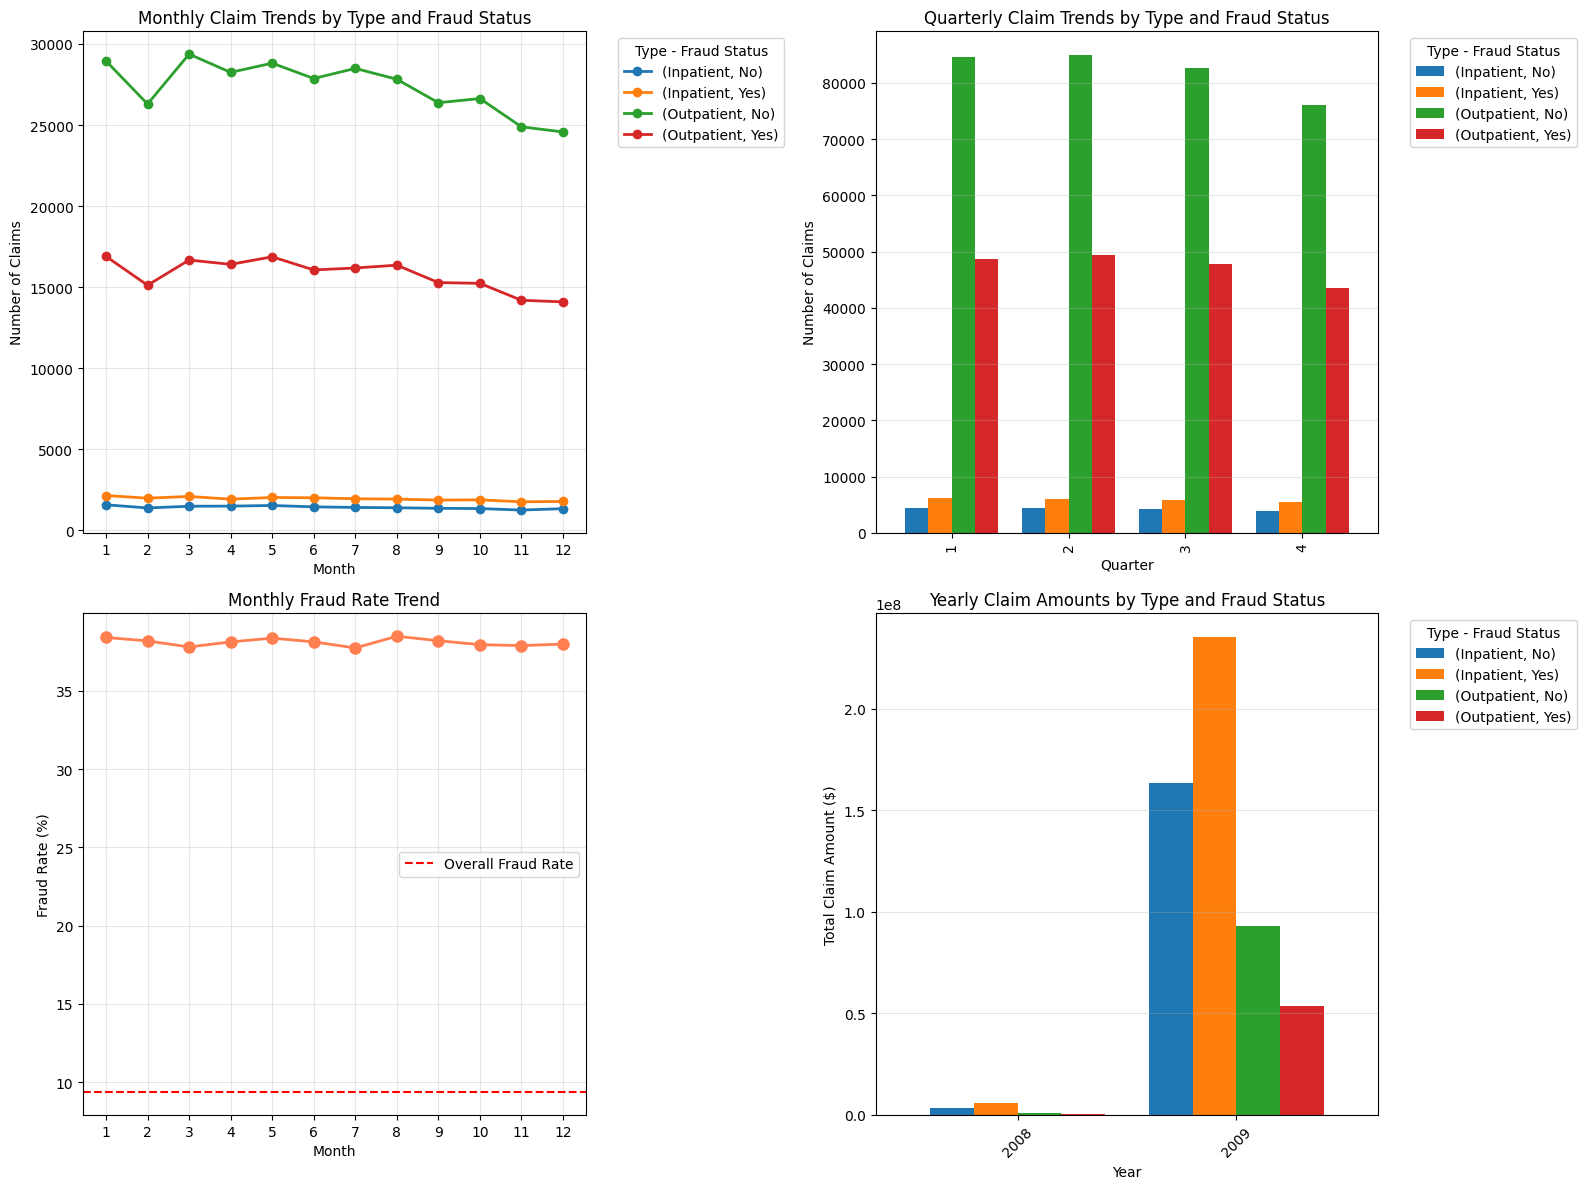


Temporal Insights:
  - Date range: 2008-11-27 to 2009-12-31
  - Month with highest fraud rate: 8 (38.50%)
  - Month with lowest fraud rate: 7 (37.75%)


In [17]:
# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Monthly claim trends
monthly_pivot = monthly_claims.pivot_table(index='ClaimMonth', columns=['Type', 'PotentialFraud'], 
                                           values='Count', fill_value=0)
monthly_pivot.plot(kind='line', ax=axes[0, 0], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Claims')
axes[0, 0].set_title('Monthly Claim Trends by Type and Fraud Status')
axes[0, 0].legend(title='Type - Fraud Status', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 13))

# 2. Quarterly claim trends
quarterly_pivot = quarterly_claims.pivot_table(index='ClaimQuarter', columns=['Type', 'PotentialFraud'], 
                                                values='Count', fill_value=0)
quarterly_pivot.plot(kind='bar', ax=axes[0, 1], width=0.8)
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Number of Claims')
axes[0, 1].set_title('Quarterly Claim Trends by Type and Fraud Status')
axes[0, 1].legend(title='Type - Fraud Status', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Monthly fraud rate
monthly_fraud_pct = monthly_claims[monthly_claims['PotentialFraud'] == 'Yes'].groupby('ClaimMonth')['Count'].sum() / \
                    monthly_claims.groupby('ClaimMonth')['Count'].sum() * 100
axes[1, 0].plot(monthly_fraud_pct.index, monthly_fraud_pct.values, marker='o', linewidth=2, 
                color='coral', markersize=8)
axes[1, 0].axhline(y=provider_geo['PotentialFraud'].eq('Yes').mean() * 100, 
                   color='red', linestyle='--', label='Overall Fraud Rate')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Fraud Rate (%)')
axes[1, 0].set_title('Monthly Fraud Rate Trend')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Yearly claim amounts by fraud status
yearly_amounts = pd.concat([
    inpatient_with_labels.groupby(['ClaimYear', 'PotentialFraud'])['InscClaimAmtReimbursed'].sum().reset_index().assign(Type='Inpatient'),
    outpatient_with_labels.groupby(['ClaimYear', 'PotentialFraud'])['InscClaimAmtReimbursed'].sum().reset_index().assign(Type='Outpatient')
])
yearly_amounts_pivot = yearly_amounts.pivot_table(index='ClaimYear', columns=['Type', 'PotentialFraud'], 
                                                   values='InscClaimAmtReimbursed', fill_value=0)
yearly_amounts_pivot.plot(kind='bar', ax=axes[1, 1], width=0.8)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Claim Amount ($)')
axes[1, 1].set_title('Yearly Claim Amounts by Type and Fraud Status')
axes[1, 1].legend(title='Type - Fraud Status', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nTemporal Insights:")
print(f"  - Date range: {inpatient['ClaimStartDt'].min().strftime('%Y-%m-%d')} to {inpatient['ClaimStartDt'].max().strftime('%Y-%m-%d')}")
print(f"  - Month with highest fraud rate: {monthly_fraud_pct.idxmax()} ({monthly_fraud_pct.max():.2f}%)")
print(f"  - Month with lowest fraud rate: {monthly_fraud_pct.idxmin()} ({monthly_fraud_pct.min():.2f}%)")


## 3. Feature Engineering - Provider Level Aggregations

### 3.1 Date Preprocessing


In [18]:
# Convert date columns
print("Processing dates...")

# Beneficiary dates
beneficiary['DOB'] = pd.to_datetime(beneficiary['DOB'], errors='coerce')
beneficiary['DOD'] = pd.to_datetime(beneficiary['DOD'], errors='coerce')

# Calculate age
beneficiary['Age'] = (pd.Timestamp('2009-12-31') - beneficiary['DOB']).dt.days / 365.25
beneficiary['Age'] = beneficiary['Age'].fillna(beneficiary['Age'].median())

# Inpatient dates
date_cols_inpatient = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols_inpatient:
    if col in inpatient.columns:
        inpatient[col] = pd.to_datetime(inpatient[col], errors='coerce')

# Calculate length of stay
inpatient['LengthOfStay'] = (inpatient['DischargeDt'] - inpatient['AdmissionDt']).dt.days
inpatient['LengthOfStay'] = inpatient['LengthOfStay'].fillna(0)

# Outpatient dates
date_cols_outpatient = ['ClaimStartDt', 'ClaimEndDt']
for col in date_cols_outpatient:
    if col in outpatient.columns:
        outpatient[col] = pd.to_datetime(outpatient[col], errors='coerce')

print("Date processing complete")


Processing dates...
Date processing complete


### 3.2 Initialize Provider Features


In [19]:
# Initialize provider features dataframe
provider_features = labels[['Provider']].copy()
provider_features['PotentialFraud'] = labels['PotentialFraud'].map({'Yes': 1, 'No': 0})

print(f"Starting with {len(provider_features)} providers")
print(f"Fraud rate: {provider_features['PotentialFraud'].mean():.2%}")


Starting with 5410 providers
Fraud rate: 9.35%


### 3.3 Inpatient Claim Features


In [21]:
# Inpatient financial aggregations
print("Creating inpatient features...")

inpatient_financial = inpatient.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'median', 'std', 'count'],
    'DeductibleAmtPaid': ['sum', 'mean'],
    'LengthOfStay': ['mean', 'median', 'sum'],
}).reset_index()

inpatient_financial.columns = ['Provider', 'IP_TotalClaimAmt', 'IP_AvgClaimAmt', 'IP_MedianClaimAmt', 
                               'IP_StdClaimAmt', 'IP_ClaimCount', 'IP_TotalDeductible', 'IP_AvgDeductible',
                               'IP_AvgLOS', 'IP_MedianLOS', 'IP_TotalLOS']

# Inpatient physician features
inpatient_physician = inpatient.groupby('Provider').agg({
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).reset_index()

inpatient_physician.columns = ['Provider', 'IP_UniqueAttendingPhys', 'IP_UniqueOperatingPhys', 'IP_UniqueOtherPhys']

# Merge inpatient features
inpatient_features = inpatient_financial.merge(inpatient_physician, on='Provider', how='left')
provider_features = provider_features.merge(inpatient_features, on='Provider', how='left')

print(f"Inpatient features added. Total features: {len(provider_features.columns)}")


Creating inpatient features...
Inpatient features added. Total features: 28


### 3.4 Outpatient Claim Features


In [22]:
# Outpatient financial aggregations
print("Creating outpatient features...")

outpatient_financial = outpatient.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'median', 'std', 'count'],
    'DeductibleAmtPaid': ['sum', 'mean'],
}).reset_index()

outpatient_financial.columns = ['Provider', 'OP_TotalClaimAmt', 'OP_AvgClaimAmt', 'OP_MedianClaimAmt',
                               'OP_StdClaimAmt', 'OP_ClaimCount', 'OP_TotalDeductible', 'OP_AvgDeductible']

# Outpatient physician features
outpatient_physician = outpatient.groupby('Provider').agg({
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).reset_index()

outpatient_physician.columns = ['Provider', 'OP_UniqueAttendingPhys', 'OP_UniqueOperatingPhys', 'OP_UniqueOtherPhys']

# Merge outpatient features
outpatient_features = outpatient_financial.merge(outpatient_physician, on='Provider', how='left')
provider_features = provider_features.merge(outpatient_features, on='Provider', how='left')

print(f"Outpatient features added. Total features: {len(provider_features.columns)}")


Creating outpatient features...
Outpatient features added. Total features: 38


### 3.5 Combined Claim Features


In [24]:
# Combined financial features
print("Creating combined features...")

provider_features['TotalClaimAmt'] = provider_features['IP_TotalClaimAmt'].fillna(0) + provider_features['OP_TotalClaimAmt'].fillna(0)
provider_features['TotalClaimCount'] = provider_features['IP_ClaimCount'].fillna(0) + provider_features['OP_ClaimCount'].fillna(0)
provider_features['AvgClaimAmt'] = provider_features['TotalClaimAmt'] / provider_features['TotalClaimCount'].replace(0, np.nan)

# IP/OP ratios
provider_features['IP_OP_Ratio_Claims'] = provider_features['IP_ClaimCount'].fillna(0) / (provider_features['OP_ClaimCount'].fillna(0) + 1)
provider_features['IP_OP_Ratio_Amount'] = provider_features['IP_TotalClaimAmt'].fillna(0) / (provider_features['OP_TotalClaimAmt'].fillna(0) + 1)

print(f"Combined features added. Total features: {len(provider_features.columns)}")


Creating combined features...


KeyError: 'IP_TotalClaimAmt'

### 3.6 Beneficiary Features (Aggregated by Provider)


In [25]:
# Get unique beneficiaries per provider from claims
print("Creating beneficiary features...")

inpatient_benes = inpatient[['Provider', 'BeneID']].drop_duplicates()
outpatient_benes = outpatient[['Provider', 'BeneID']].drop_duplicates()
all_benes = pd.concat([inpatient_benes, outpatient_benes]).drop_duplicates()

# Merge with beneficiary data
benes_with_data = all_benes.merge(beneficiary, on='BeneID', how='left')

# Aggregate beneficiary features by provider
beneficiary_features = benes_with_data.groupby('Provider').agg({
    'BeneID': 'count',
    'Age': ['mean', 'median', 'std'],
    'Gender': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0,  # % male
    'State': 'nunique',
    'County': 'nunique',
    'ChronicCond_Alzheimer': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0,
    'ChronicCond_Heartfailure': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0,
    'ChronicCond_KidneyDisease': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0,
    'ChronicCond_Cancer': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0,
    'ChronicCond_Diabetes': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0,
    'IPAnnualReimbursementAmt': 'mean',
    'OPAnnualReimbursementAmt': 'mean'
}).reset_index()

beneficiary_features.columns = ['Provider', 'UniquePatients', 'AvgPatientAge', 'MedianPatientAge', 'StdPatientAge',
                               'PctMale', 'UniqueStates', 'UniqueCounties', 'PctAlzheimer', 'PctHeartfailure',
                               'PctKidneyDisease', 'PctCancer', 'PctDiabetes', 'AvgIPAnnualReimb', 'AvgOPAnnualReimb']

provider_features = provider_features.merge(beneficiary_features, on='Provider', how='left')

print(f"Beneficiary features added. Total features: {len(provider_features.columns)}")


Creating beneficiary features...
Beneficiary features added. Total features: 52


### 3.7 Fill Missing Values


In [26]:
# Fill missing values with 0 for count/sum features, median for averages
print("Filling missing values...")

numeric_cols = provider_features.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'PotentialFraud']

for col in numeric_cols:
    if 'Count' in col or 'Total' in col or 'Sum' in col or 'Unique' in col:
        provider_features[col] = provider_features[col].fillna(0)
    else:
        provider_features[col] = provider_features[col].fillna(provider_features[col].median())

print(f"Final feature shape: {provider_features.shape}")
print(f"Features created: {len(provider_features.columns) - 2}")  # Excluding Provider and PotentialFraud


Filling missing values...
Final feature shape: (5410, 52)
Features created: 50


## 4. Save Processed Features


In [27]:
# Save processed features (ALL features before selection)
import os
if os.path.exists('../data/processed'):
    processed_path = '../data/processed'
elif os.path.exists('data/processed'):
    processed_path = 'data/processed'
else:
    processed_path = r'c:\MachineLearning2\DataOrbit---HealthCare-Provider-Fraud-Detection-Project\data\processed'

output_path = os.path.join(processed_path, 'provider_features_train.csv')
provider_features.to_csv(output_path, index=False)
print(f"Features saved to {output_path}")


Features saved to ../data/processed\provider_features_train.csv


## 5. Feature Summary


In [28]:
print("=== Feature Summary ===")
print(f"Total providers: {len(provider_features)}")
print(f"Total features: {len(provider_features.columns) - 2}")
print(f"\nFraud distribution:")
print(provider_features['PotentialFraud'].value_counts())
print(f"\nFraud rate: {provider_features['PotentialFraud'].mean():.2%}")

print(f"\nFeature columns:")
print(list(provider_features.columns))


=== Feature Summary ===
Total providers: 5410
Total features: 50

Fraud distribution:
PotentialFraud
0    4904
1     506
Name: count, dtype: int64

Fraud rate: 9.35%

Feature columns:
['Provider', 'PotentialFraud', 'IP_TotalClaimAmt_x', 'IP_AvgClaimAmt_x', 'IP_MedianClaimAmt_x', 'IP_StdClaimAmt_x', 'IP_ClaimCount_x', 'IP_TotalDeductible_x', 'IP_AvgDeductible_x', 'IP_AvgLOS_x', 'IP_MedianLOS_x', 'IP_TotalLOS_x', 'IP_UniqueAttendingPhys_x', 'IP_UniqueOperatingPhys_x', 'IP_UniqueOtherPhys_x', 'IP_TotalClaimAmt_y', 'IP_AvgClaimAmt_y', 'IP_MedianClaimAmt_y', 'IP_StdClaimAmt_y', 'IP_ClaimCount_y', 'IP_TotalDeductible_y', 'IP_AvgDeductible_y', 'IP_AvgLOS_y', 'IP_MedianLOS_y', 'IP_TotalLOS_y', 'IP_UniqueAttendingPhys_y', 'IP_UniqueOperatingPhys_y', 'IP_UniqueOtherPhys_y', 'OP_TotalClaimAmt', 'OP_AvgClaimAmt', 'OP_MedianClaimAmt', 'OP_StdClaimAmt', 'OP_ClaimCount', 'OP_TotalDeductible', 'OP_AvgDeductible', 'OP_UniqueAttendingPhys', 'OP_UniqueOperatingPhys', 'OP_UniqueOtherPhys', 'UniquePatients

## 6. Feature Selection & Importance Analysis




In [29]:
# Feature importance using correlation with target
from scipy.stats import pearsonr

# Calculate correlation with target
feature_importance = []
feature_cols = [col for col in provider_features.columns if col not in ['Provider', 'PotentialFraud']]

for col in feature_cols:
    if provider_features[col].dtype in [np.int64, np.float64]:
        corr, p_value = pearsonr(provider_features[col].fillna(0), provider_features['PotentialFraud'])
        feature_importance.append({
            'Feature': col,
            'Correlation': abs(corr),
            'P_Value': p_value,
            'Direction': 'Positive' if corr > 0 else 'Negative'
        })

importance_df = pd.DataFrame(feature_importance).sort_values('Correlation', ascending=False)
print("Top 20 Most Important Features (by correlation with fraud):")
print(importance_df.head(20))


Top 20 Most Important Features (by correlation with fraud):
                     Feature  Correlation        P_Value Direction
0         IP_TotalClaimAmt_x     0.532795   0.000000e+00  Positive
13        IP_TotalClaimAmt_y     0.532795   0.000000e+00  Positive
9              IP_TotalLOS_x     0.526016   0.000000e+00  Positive
22             IP_TotalLOS_y     0.526016   0.000000e+00  Positive
18      IP_TotalDeductible_y     0.525454   0.000000e+00  Positive
5       IP_TotalDeductible_x     0.525454   0.000000e+00  Positive
4            IP_ClaimCount_x     0.525393   0.000000e+00  Positive
17           IP_ClaimCount_y     0.525393   0.000000e+00  Positive
36            UniquePatients     0.393531  7.010207e-200  Positive
42            UniqueCounties     0.372852  4.854972e-178  Positive
26          OP_TotalClaimAmt     0.337756  1.826783e-144  Positive
30             OP_ClaimCount     0.335803  1.015486e-142  Positive
24  IP_UniqueOperatingPhys_y     0.333779  6.333850e-141  Positive
11

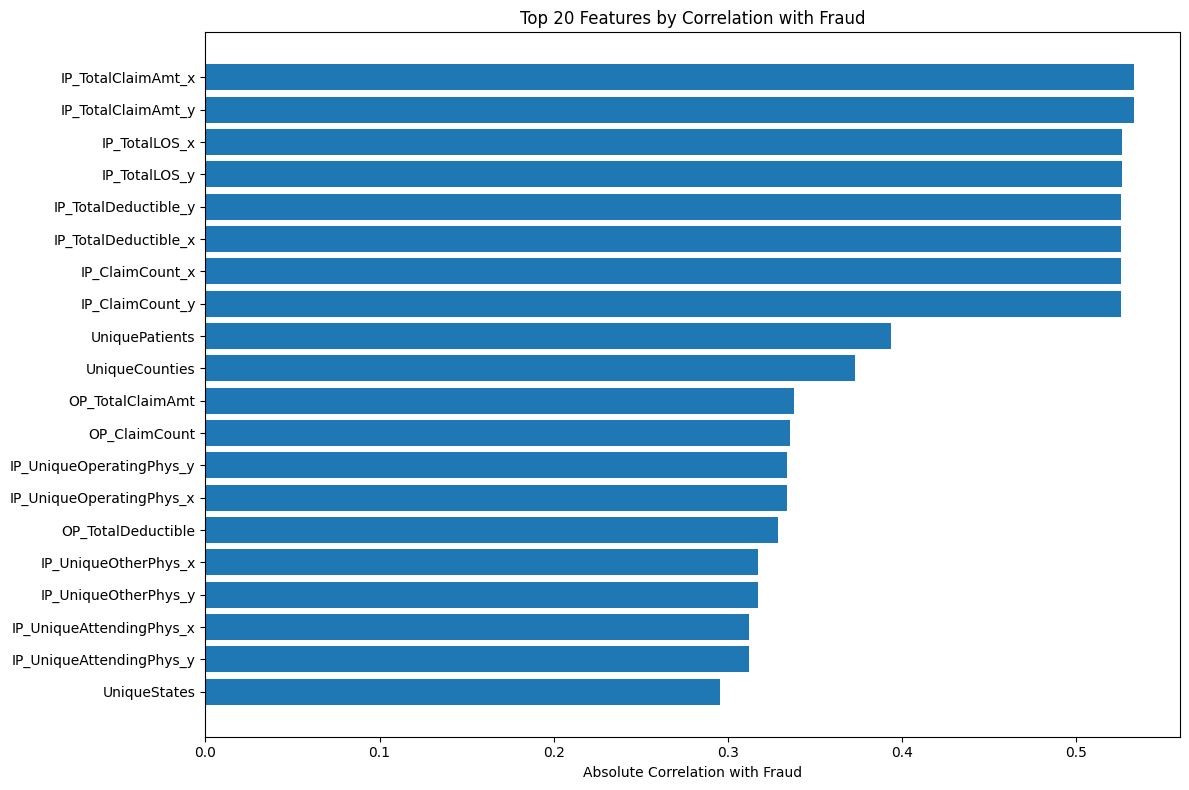

In [30]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Correlation'].values)
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Absolute Correlation with Fraud')
plt.title('Top 20 Features by Correlation with Fraud')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 6.1 Select Features for Modeling


In [31]:
# Select features with significant correlation (p-value < 0.05) or high correlation
selected_features = importance_df[
    (importance_df['P_Value'] < 0.05) | (importance_df['Correlation'] > 0.1)
]['Feature'].tolist()

print(f"Selected {len(selected_features)} features for modeling")
print(f"\nSelected features:")
print(selected_features)

# Create final dataset with selected features
final_features = provider_features[['Provider', 'PotentialFraud'] + selected_features].copy()
print(f"\nFinal dataset shape: {final_features.shape}")


Selected 43 features for modeling

Selected features:
['IP_TotalClaimAmt_x', 'IP_TotalClaimAmt_y', 'IP_TotalLOS_x', 'IP_TotalLOS_y', 'IP_TotalDeductible_y', 'IP_TotalDeductible_x', 'IP_ClaimCount_x', 'IP_ClaimCount_y', 'UniquePatients', 'UniqueCounties', 'OP_TotalClaimAmt', 'OP_ClaimCount', 'IP_UniqueOperatingPhys_y', 'IP_UniqueOperatingPhys_x', 'OP_TotalDeductible', 'IP_UniqueOtherPhys_x', 'IP_UniqueOtherPhys_y', 'IP_UniqueAttendingPhys_x', 'IP_UniqueAttendingPhys_y', 'UniqueStates', 'OP_UniqueOperatingPhys', 'OP_UniqueAttendingPhys', 'OP_UniqueOtherPhys', 'IP_StdClaimAmt_x', 'IP_StdClaimAmt_y', 'AvgIPAnnualReimb', 'IP_AvgClaimAmt_x', 'IP_AvgClaimAmt_y', 'IP_AvgLOS_y', 'IP_AvgLOS_x', 'OP_StdClaimAmt', 'PctKidneyDisease', 'OP_AvgClaimAmt', 'OP_AvgDeductible', 'PctHeartfailure', 'OP_MedianClaimAmt', 'StdPatientAge', 'IP_MedianLOS_y', 'IP_MedianLOS_x', 'PctDiabetes', 'PctAlzheimer', 'IP_MedianClaimAmt_x', 'IP_MedianClaimAmt_y']

Final dataset shape: (5410, 45)


### 6.2 Check for Multicollinearity


Highly correlated feature pairs (|correlation| > 0.8):
                    Feature1                  Feature2  Correlation
0         IP_TotalClaimAmt_x        IP_TotalClaimAmt_y     1.000000
1         IP_TotalClaimAmt_x             IP_TotalLOS_x     0.991390
2         IP_TotalClaimAmt_x             IP_TotalLOS_y     0.991390
3         IP_TotalClaimAmt_x      IP_TotalDeductible_y     0.992380
4         IP_TotalClaimAmt_x      IP_TotalDeductible_x     0.992380
5         IP_TotalClaimAmt_x           IP_ClaimCount_x     0.992523
6         IP_TotalClaimAmt_x           IP_ClaimCount_y     0.992523
7         IP_TotalClaimAmt_y             IP_TotalLOS_x     0.991390
8         IP_TotalClaimAmt_y             IP_TotalLOS_y     0.991390
9         IP_TotalClaimAmt_y      IP_TotalDeductible_y     0.992380
10        IP_TotalClaimAmt_y      IP_TotalDeductible_x     0.992380
11        IP_TotalClaimAmt_y           IP_ClaimCount_x     0.992523
12        IP_TotalClaimAmt_y           IP_ClaimCount_y     0.

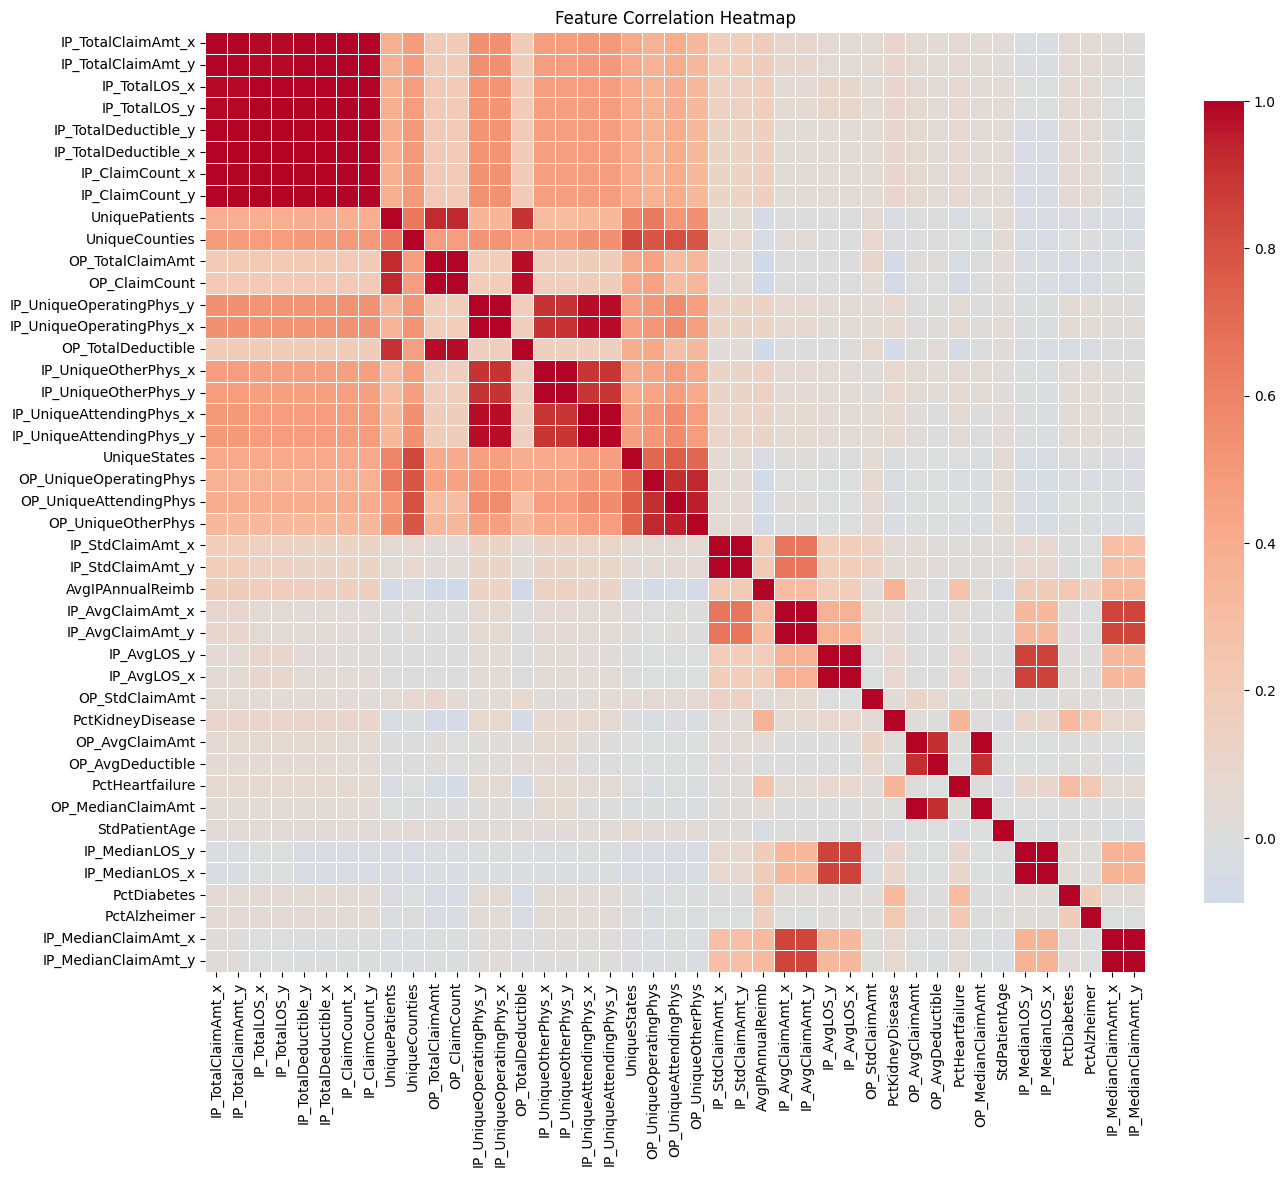

In [32]:
# Check correlation between features (multicollinearity)
feature_corr = final_features[selected_features].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature1': feature_corr.columns[i],
                'Feature2': feature_corr.columns[j],
                'Correlation': feature_corr.iloc[i, j]
            })

if high_corr_pairs:
    print("Highly correlated feature pairs (|correlation| > 0.8):")
    print(pd.DataFrame(high_corr_pairs))
else:
    print("No highly correlated feature pairs found (threshold: 0.8)")

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(feature_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


## 7. Final Feature Dataset

**Ready for modeling**


In [33]:
# Save final feature dataset (ONLY selected features for modeling)
import os
if os.path.exists('../data/processed'):
    processed_path = '../data/processed'
elif os.path.exists('data/processed'):
    processed_path = 'data/processed'
else:
    processed_path = r'c:\MachineLearning2\DataOrbit---HealthCare-Provider-Fraud-Detection-Project\data\processed'

output_path_final = os.path.join(processed_path, 'provider_features_final_train.csv')
final_features.to_csv(output_path_final, index=False)

print("=" * 50)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 50)
print(f"Total providers: {len(final_features)}")
print(f"Total features selected: {len(selected_features)}")
print(f"Fraud rate: {final_features['PotentialFraud'].mean():.2%}")
print(f"\nFinal dataset saved to: {output_path_final}")
print("\nDataset is ready for modeling!")


FEATURE ENGINEERING COMPLETE
Total providers: 5410
Total features selected: 43
Fraud rate: 9.35%

Final dataset saved to: ../data/processed\provider_features_final_train.csv

Dataset is ready for modeling!
